### 1．インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from urllib.request import urlopen

### 1.1　クラス

In [2]:
# 訓練データと出馬表データを加工する抽象クラス
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame()
        # preprocessing後の変数
        self.data_p = pd.DataFrame()
        # horse_resultsをmergeした後の変数
        self.data_h = pd.DataFrame()
        # pedsをmergeした後の変数
        self.data_pe = pd.DataFrame()
        # カテゴリ変数化した後の変数
        self.data_c = pd.DataFrame()
        
    # 馬の過去成績データの追加
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
            
    # 血統データ追加
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds, left_on='horse_id', right_index=True, how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]['horse_id'].unique()
        if len(self.no_peds):
            print('scrape peds at horse_id_list "no_peds"')
    
    # カテゴリ変数の処理
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        # ラベルエンコーディング(horse_id, jockey_idを0始まりの整数に変換)
        # horse_id
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        # jockey_id
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        # horse_id, jockey_idをcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        # そのほかのカテゴリ変数をcategory型に変換してからダミー変数化
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])  
        self.data_c = df

# 予測に使う出馬表データを加工するクラス
class ShutubaTable(DataProcessor):
    def __init__(self):
        super(ShutubaTable, self).__init__()
        
    def scrape(self, race_id_list, date):
        for race_id in tqdm(race_id_list):
            url = f'https://race.netkeiba.com/race/shutuba.html?race_id={race_id}'
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            # race_data
            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    df['weather'] = [text] * len(df)
                if text in ["良", "稍重", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            df['horse_id'] = horse_id_list

            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            self.data = self.data.append(df)
            time.sleep(1)
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()
        
        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df['馬体重(増減)'] != '--']
        df['体重'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].astype(int)
        
        # 日付をdatetime型に変更
        df['date'] = pd.to_datetime(df['date'])

        # データをint, floatに変換
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

    
        # 必要な列だけにする
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather', 'race_type', 'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢', '体重', '体重変化']]

        self.data_p = df.rename(columns={'枠': '枠番'})

# 訓練に使う過去レースデータを加工するクラス
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df = df[~(df['着順'].astype(str).str.contains('\D'))]
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].astype(int)

        # 不要な列を削除
        df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手', '単勝', '人気', '着順'], axis=1, inplace=True)

        df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

        self.data_p = df
    
    # カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])        
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

# 馬の過去成績データを処理するクラス
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金']]
        self.preprocessing()
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
            
        average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        rename_columns = average.rename(columns={'着順': f'着順_{n_samples}R', '賞金': f'賞金_{n_samples}R'})
        return rename_columns
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df

# 血統データを処理するクラス
class Peds:
    def __init__(self, peds):
        self.peds = peds
        # LabelEncodingしてcategory型にした変数
        self.peds_e = pd.DataFrame()
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')

# 払い戻しデータを加工するクラス
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho

# 予測モデルを評価するクラス
class ModelEvaluator:
    def __init__(self, model, return_tables, std=True):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
        self.std = std
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        proba = pd.Series(self.model.predict_proba(x)[:, 1], index=x.index)
        if self.std:
            # 標準化
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            # MinMaxスケーリング：データを0から1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1]['馬番']
        
        return pred_table
    
    def fukusho_return(self, x, threshold=0.5):
        # 複勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, x, threshold=0.5):
        # 単勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win'] == df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        # 単勝適性回収値を計算
        return_rate = len(df.query('win == 馬番')) / (100 / df['return']).sum()
        
        return n_bets, return_rate

### 1.2　関数

In [15]:
# 時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

# 回収率を計算する関数
def gain(return_func, x, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = (i / n_samples) + (min_threshold * (1 - (i / n_samples)))
        n_bets, return_rate = return_func(x, threshold)
        if n_bets > lower:
            gain[n_bets] = return_rate
    return pd.Series(gain)

### 1.3　pickleファイル 

In [4]:
# 過去のレースデータ
results = pd.read_pickle('results.pickle')

# 馬の過去成績データ
horse_results = pd.read_pickle('horse_results.pickle')

# 払い戻し金額データ
return_tables = pd.read_pickle('return_tables.pickle')

# 5世代血統データ
peds = pd.read_pickle('peds.pickle')

### 2．前処理

In [5]:
r = Results(results)

# 前処理
r.preprocessing()

# 馬の過去成績データの追加
hr = HorseResults(horse_results)
r.merge_horse_results(hr)

# 5世代分の血統データの追加
p = Peds(peds)
p.encode()
r.merge_peds(p.peds_e)

# カテゴリ変数の処理
r.process_categorical()

### 3．予測

In [6]:
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [7]:
params = {
    'num_leaves': 4,
    'n_estimators': 80,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [8]:
me = ModelEvaluator(lgb_clf, return_tables)

100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


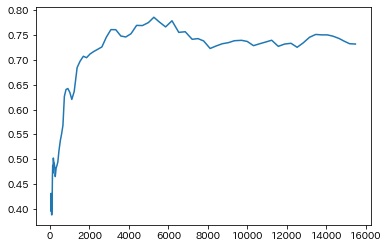

In [9]:
baseline = gain(me.tansho_return, X_test)
baseline.plot()

#### 4．単勝適性回収値
常に払戻額が一定になるように単勝で賭けた場合の回収率<br>
払戻額が常に1万円になるように賭けてみる

賭けた金額<br>
x円賭けるとすると<br>
$$
各馬番の単勝オッズ \times \frac{x}{100} = 10000 \\
\therefore \quad x = \frac{100 \times 10000}{各馬番の単勝オッズ}
$$

回収率 = 払戻額 / 賭けた金額

100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


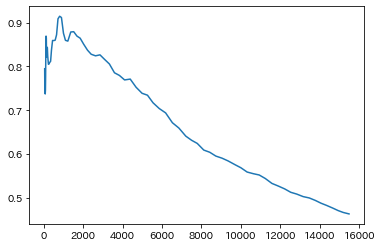

In [10]:
gain_proper = gain(me.tansho_return_proper, X_test)
gain_proper.plot()

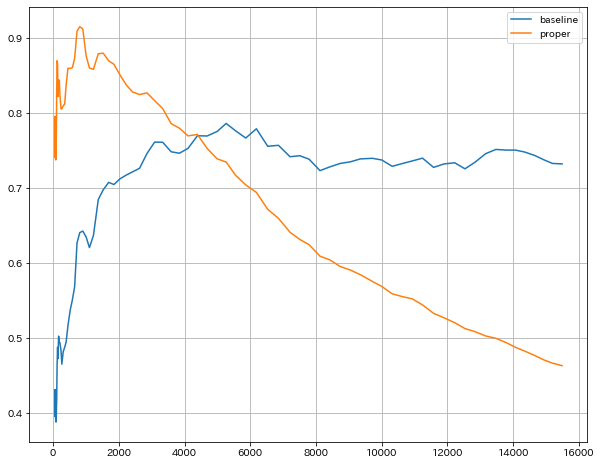

In [12]:
plt.figure(figsize=(10, 8))
baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
plt.grid()

### 5．Optuna

In [16]:
train, test = split_data(r.data_c)
train, valid = split_data(train)

In [22]:
import optuna.integration.lightgbm as lgb_o

# 説明変数と目的変数に分ける
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [23]:
# データセットの作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# チューニング実行
params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

C:\Users\y_ono\Anaconda\lib\site-packages\optuna\_experimental.py:61: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  "The interface can change in the future.".format(
C:\Users\y_ono\Anaconda\lib\site-packages\optuna\_experimental.py:83: ExperimentalWarning: LightGBMTuner is experimental (supported from v1.5.0). The interface can change in the future.
  "The interface can change in the future.".format(
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.436656	valid_1's binary_logloss: 0.467666


feature_fraction, val_score: 0.467666:  14%|#4        | 1/7 [00:02<00:14,  2.49s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.422333	valid_1's binary_logloss: 0.46694


feature_fraction, val_score: 0.466940:  29%|##8       | 2/7 [00:04<00:11,  2.35s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.432324	valid_1's binary_logloss: 0.465903


feature_fraction, val_score: 0.465903:  43%|####2     | 3/7 [00:06<00:08,  2.24s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.435011	valid_1's binary_logloss: 0.467842


feature_fraction, val_score: 0.465903:  57%|#####7    | 4/7 [00:09<00:06,  2.28s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.428393	valid_1's binary_logloss: 0.466295


feature_fraction, val_score: 0.465903:  71%|#######1  | 5/7 [00:11<00:04,  2.28s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.430351	valid_1's binary_logloss: 0.466859


feature_fraction, val_score: 0.465903:  86%|########5 | 6/7 [00:12<00:02,  2.02s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.439963	valid_1's binary_logloss: 0.467039


num_leaves, val_score: 0.465903:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.360615	valid_1's binary_logloss: 0.46998


num_leaves, val_score: 0.465903:   5%|5         | 1/20 [00:03<01:01,  3.22s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.360615	valid_1's binary_logloss: 0.46998


num_leaves, val_score: 0.465903:  10%|#         | 2/20 [00:06<00:56,  3.14s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.360039	valid_1's binary_logloss: 0.470562


num_leaves, val_score: 0.465903:  15%|#5        | 3/20 [00:10<00:55,  3.28s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.351216	valid_1's binary_logloss: 0.473643


num_leaves, val_score: 0.465903:  20%|##        | 4/20 [00:13<00:54,  3.43s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.352733	valid_1's binary_logloss: 0.470974


num_leaves, val_score: 0.465903:  25%|##5       | 5/20 [00:16<00:50,  3.35s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.366271	valid_1's binary_logloss: 0.471406


num_leaves, val_score: 0.465903:  30%|###       | 6/20 [00:20<00:47,  3.37s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.40227	valid_1's binary_logloss: 0.467551


num_leaves, val_score: 0.465903:  35%|###5      | 7/20 [00:22<00:38,  3.00s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.34455	valid_1's binary_logloss: 0.472539


num_leaves, val_score: 0.465903:  40%|####      | 8/20 [00:27<00:41,  3.44s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.354116	valid_1's binary_logloss: 0.472524


num_leaves, val_score: 0.465903:  45%|####5     | 9/20 [00:30<00:38,  3.52s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.366561	valid_1's binary_logloss: 0.470737


num_leaves, val_score: 0.465903:  50%|#####     | 10/20 [00:33<00:33,  3.39s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.423984	valid_1's binary_logloss: 0.46722


num_leaves, val_score: 0.465903:  55%|#####5    | 11/20 [00:36<00:27,  3.09s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.413771	valid_1's binary_logloss: 0.467341


num_leaves, val_score: 0.465903:  60%|######    | 12/20 [00:38<00:22,  2.84s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.472879	valid_1's binary_logloss: 0.472613
[200]	training's binary_logloss: 0.467537	valid_1's binary_logloss: 0.470243
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.465034	valid_1's binary_logloss: 0.46941


num_leaves, val_score: 0.465903:  65%|######5   | 13/20 [00:40<00:17,  2.56s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.416358	valid_1's binary_logloss: 0.467211


num_leaves, val_score: 0.465903:  70%|#######   | 14/20 [00:42<00:15,  2.52s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.404568	valid_1's binary_logloss: 0.468059


num_leaves, val_score: 0.465903:  75%|#######5  | 15/20 [00:44<00:11,  2.39s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455346	valid_1's binary_logloss: 0.46679
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.446475	valid_1's binary_logloss: 0.465939


num_leaves, val_score: 0.465903:  80%|########  | 16/20 [00:47<00:09,  2.33s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446745	valid_1's binary_logloss: 0.465992
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439058	valid_1's binary_logloss: 0.465511


num_leaves, val_score: 0.465511:  85%|########5 | 17/20 [00:48<00:06,  2.15s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.478449	valid_1's binary_logloss: 0.476674
[200]	training's binary_logloss: 0.475084	valid_1's binary_logloss: 0.474808
[300]	training's binary_logloss: 0.473017	valid_1's binary_logloss: 0.473572
[400]	training's binary_logloss: 0.471517	valid_1's binary_logloss: 0.472851
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.471584	valid_1's binary_logloss: 0.472835


num_leaves, val_score: 0.465511:  90%|######### | 18/20 [00:50<00:04,  2.14s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.449164	valid_1's binary_logloss: 0.466464


num_leaves, val_score: 0.465511:  95%|#########5| 19/20 [00:52<00:01,  1.96s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.397178	valid_1's binary_logloss: 0.469613


bagging, val_score: 0.465511:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.449537	valid_1's binary_logloss: 0.466971


bagging, val_score: 0.465511:  10%|#         | 1/10 [00:01<00:09,  1.04s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.456329	valid_1's binary_logloss: 0.470216


bagging, val_score: 0.465511:  20%|##        | 2/10 [00:02<00:07,  1.01it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.452639	valid_1's binary_logloss: 0.469146


bagging, val_score: 0.465511:  30%|###       | 3/10 [00:03<00:08,  1.18s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446136	valid_1's binary_logloss: 0.466851
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.445887	valid_1's binary_logloss: 0.466806


bagging, val_score: 0.465511:  40%|####      | 4/10 [00:05<00:07,  1.29s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.451149	valid_1's binary_logloss: 0.466642


bagging, val_score: 0.465511:  50%|#####     | 5/10 [00:06<00:06,  1.27s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.45401	valid_1's binary_logloss: 0.466664


bagging, val_score: 0.465511:  60%|######    | 6/10 [00:07<00:05,  1.27s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.451505	valid_1's binary_logloss: 0.468703


bagging, val_score: 0.465511:  70%|#######   | 7/10 [00:09<00:04,  1.36s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446113	valid_1's binary_logloss: 0.466251
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.438735	valid_1's binary_logloss: 0.466065


bagging, val_score: 0.465511:  80%|########  | 8/10 [00:11<00:03,  1.57s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.458288	valid_1's binary_logloss: 0.468321


bagging, val_score: 0.465511:  90%|######### | 9/10 [00:12<00:01,  1.39s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.455091	valid_1's binary_logloss: 0.467169


feature_fraction_stage2, val_score: 0.465511:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446166	valid_1's binary_logloss: 0.465867
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.443756	valid_1's binary_logloss: 0.465609


feature_fraction_stage2, val_score: 0.465511:  17%|#6        | 1/6 [00:01<00:08,  1.73s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.455508	valid_1's binary_logloss: 0.466656


feature_fraction_stage2, val_score: 0.465511:  33%|###3      | 2/6 [00:02<00:06,  1.52s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.454507	valid_1's binary_logloss: 0.465995


feature_fraction_stage2, val_score: 0.465511:  50%|#####     | 3/6 [00:04<00:04,  1.40s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445858	valid_1's binary_logloss: 0.466189
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.446641	valid_1's binary_logloss: 0.466086


feature_fraction_stage2, val_score: 0.465511:  67%|######6   | 4/6 [00:05<00:02,  1.41s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447613	valid_1's binary_logloss: 0.466525
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.44637	valid_1's binary_logloss: 0.466383


feature_fraction_stage2, val_score: 0.465511:  83%|########3 | 5/6 [00:07<00:01,  1.64s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446316	valid_1's binary_logloss: 0.466111
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.444011	valid_1's binary_logloss: 0.465935


regularization_factors, val_score: 0.465511:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446746	valid_1's binary_logloss: 0.465992
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439061	valid_1's binary_logloss: 0.465511


regularization_factors, val_score: 0.465511:   5%|5         | 1/20 [00:01<00:29,  1.54s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446745	valid_1's binary_logloss: 0.465992
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439059	valid_1's binary_logloss: 0.465506


regularization_factors, val_score: 0.465506:  10%|#         | 2/20 [00:03<00:30,  1.69s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.450654	valid_1's binary_logloss: 0.46596


regularization_factors, val_score: 0.465506:  15%|#5        | 3/20 [00:05<00:26,  1.58s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.452405	valid_1's binary_logloss: 0.465771


regularization_factors, val_score: 0.465506:  20%|##        | 4/20 [00:06<00:23,  1.50s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446757	valid_1's binary_logloss: 0.465991
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.443758	valid_1's binary_logloss: 0.465729


regularization_factors, val_score: 0.465506:  25%|##5       | 5/20 [00:08<00:24,  1.61s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.451043	valid_1's binary_logloss: 0.466135
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.451448	valid_1's binary_logloss: 0.466035


regularization_factors, val_score: 0.465506:  30%|###       | 6/20 [00:10<00:23,  1.66s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.44675	valid_1's binary_logloss: 0.465991
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439066	valid_1's binary_logloss: 0.465506


regularization_factors, val_score: 0.465506:  35%|###5      | 7/20 [00:12<00:22,  1.75s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.452391	valid_1's binary_logloss: 0.465891


regularization_factors, val_score: 0.465506:  40%|####      | 8/20 [00:14<00:24,  2.06s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447436	valid_1's binary_logloss: 0.465857
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.446277	valid_1's binary_logloss: 0.465501


regularization_factors, val_score: 0.465501:  45%|####5     | 9/20 [00:16<00:20,  1.90s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.45179	valid_1's binary_logloss: 0.466357


regularization_factors, val_score: 0.465501:  50%|#####     | 10/20 [00:17<00:16,  1.69s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.455639	valid_1's binary_logloss: 0.467039


regularization_factors, val_score: 0.465501:  55%|#####5    | 11/20 [00:18<00:13,  1.52s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.450068	valid_1's binary_logloss: 0.465912


regularization_factors, val_score: 0.465501:  60%|######    | 12/20 [00:20<00:12,  1.55s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446745	valid_1's binary_logloss: 0.465992
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439058	valid_1's binary_logloss: 0.465511


regularization_factors, val_score: 0.465501:  65%|######5   | 13/20 [00:22<00:12,  1.72s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446453	valid_1's binary_logloss: 0.466419
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.44464	valid_1's binary_logloss: 0.466101


regularization_factors, val_score: 0.465501:  70%|#######   | 14/20 [00:24<00:10,  1.73s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446745	valid_1's binary_logloss: 0.465992
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439058	valid_1's binary_logloss: 0.465511


regularization_factors, val_score: 0.465501:  75%|#######5  | 15/20 [00:26<00:09,  1.92s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.450066	valid_1's binary_logloss: 0.465912


regularization_factors, val_score: 0.465501:  80%|########  | 16/20 [00:28<00:07,  1.79s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446752	valid_1's binary_logloss: 0.465991
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.443752	valid_1's binary_logloss: 0.46573


regularization_factors, val_score: 0.465501:  85%|########5 | 17/20 [00:30<00:06,  2.06s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446746	valid_1's binary_logloss: 0.465991
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439061	valid_1's binary_logloss: 0.465506


regularization_factors, val_score: 0.465501:  90%|######### | 18/20 [00:32<00:04,  2.04s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447067	valid_1's binary_logloss: 0.465764
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.448558	valid_1's binary_logloss: 0.465705


regularization_factors, val_score: 0.465501:  95%|#########5| 19/20 [00:34<00:01,  1.93s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446745	valid_1's binary_logloss: 0.465992
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.439058	valid_1's binary_logloss: 0.465511


min_data_in_leaf, val_score: 0.465501:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447289	valid_1's binary_logloss: 0.46679
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.446479	valid_1's binary_logloss: 0.46672


min_data_in_leaf, val_score: 0.465501:  20%|##        | 1/5 [00:01<00:05,  1.33s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.454852	valid_1's binary_logloss: 0.46657


min_data_in_leaf, val_score: 0.465501:  40%|####      | 2/5 [00:02<00:03,  1.29s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447987	valid_1's binary_logloss: 0.465646
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.441749	valid_1's binary_logloss: 0.465181


min_data_in_leaf, val_score: 0.465181:  60%|######    | 3/5 [00:04<00:03,  1.53s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447368	valid_1's binary_logloss: 0.466293
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.443402	valid_1's binary_logloss: 0.465951


min_data_in_leaf, val_score: 0.465181:  80%|########  | 4/5 [00:06<00:01,  1.58s/it]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.452494	valid_1's binary_logloss: 0.466918


min_data_in_leaf, val_score: 0.465181: 100%|##########| 5/5 [00:08<00:00,  1.61s/it]


1．あるハイパーパラメータを使って、lgb_trainで学習<br>
2．そのモデルを使ってlgb_validで検証<br>
3．検証結果を利用して、ハイパーパラメータを変えてlgb_trainで再学習<br>
4．2～3を繰り返す

In [24]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'lambda_l1': 1.044331469685313,
 'lambda_l2': 0.0006884053717377605,
 'num_leaves': 13,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100}

In [25]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.6,
               lambda_l1=1.044331469685313, lambda_l2=0.0006884053717377605,
               min_child_samples=100, num_leaves=13, objective='binary',
               random_state=100)

In [26]:
me2 = ModelEvaluator(lgb_clf, return_tables)

In [27]:
gain_optuna = gain(me2.tansho_return_proper, X_test)

100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


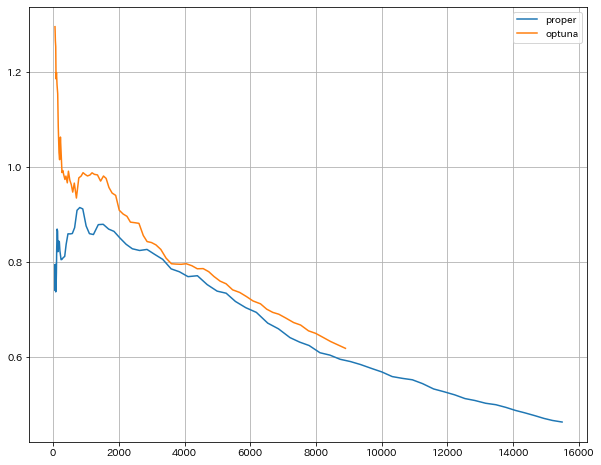

In [28]:
plt.figure(figsize=(10, 8))
gain_proper.rename('proper').plot(legend=True)
gain_optuna.rename('optuna').plot(legend=True)
plt.grid()

In [29]:
gain_optuna.max()

1.2956211704963414